In [24]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from brukeropusreader import read_file
from scipy.interpolate import interp1d
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal


In [25]:


# Define folder paths
folder_path_oe = 'Spectra RE'
folder_path_re = 'Spectra OE'
folder_path_trachea = 'Spectra TR'

# Function to list files in a folder
def list_files(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

# List files in each folder
files_re = list_files(folder_path_re)
files_oe = list_files(folder_path_oe)
files_tr = list_files(folder_path_trachea)

# Displaying file names and their count
print("RE Folder:")
print(f"Number of files: {len(files_re)}")
print("Files:", files_re)





RE Folder:
Number of files: 210
Files: ['20240408 A5 OE.0004', '20240408 A5 OE.0003', '20240408 A2 OE.0001', '15012024 OE 4.0000', '15012024 OE 3.0012', '20240311 OE 1.0003', '19022024 OE 4.0004', '05022024 OE 1 mit max druck.0004', '20240415 B5 OE.0002', '20240415 B2 OE.0000', '20240311 OE 1.0004', '05022024 OE 1 mit max druck.0003', '20240318 OE A2.0000', '20240311 OE 5.0001', '19022024 OE 4.0003', '20240304 OE 3.0000', '15012024 OE 3.0013', '15012024 OE 4.0001', '15012024 OE 3.0014', '20240408 A5 OE.0002', '20240408 A2 OE.0000', '20240304 OE 3.0001', '20240311 OE 5.0000', '19022024 OE 4.0002', '20240318 OE A2.0001', '05022024 OE 1 mit max druck.0002', '20240415 B5 OE.0004', '20240311 OE 1.0002', '20240415 B5 OE.0003', '20240415 B2 OE.0001', '19022024 OE 1.0000', '19022024 OE 5.0002', '20240318 OE A3.0001', '05022024 OE 2 mit max druck.0002', '05022024 OE 5 mit max druck.0000', '20240408 A3 OE.0000', '20240408 A4 OE.0002', '20240304 OE 2.0001', '15012024 OE 1.0004', '15012024 OE 5.00

In [26]:

# Define the common set of wavenumbers
start_wavenumber = 5000  # Starting wavenumber
end_wavenumber = 400  # Ending wavenumber
resolution = 1  # Resolution in cm⁻¹

# Generate the common set of wavenumbers
common_wavenumbers = np.arange(start_wavenumber, end_wavenumber - resolution, -resolution)

# Verify the first and last values as well as the size of the set to ensure it matches expectations
print("First wavenumber:", common_wavenumbers[0])
print("Last wavenumber:", common_wavenumbers[-1])
print("Total number of points:", len(common_wavenumbers))

def get_wavenumbers(file_path):
    opus_data = read_file(file_path)
    num_points = len(opus_data['AB'])
    start_wn = opus_data['AB Data Parameter']['FXV']
    end_wn = opus_data['AB Data Parameter']['LXV']
    wavenumbers = np.linspace(start_wn, end_wn, num_points)
    return wavenumbers

def get_spectral_data(file_path):
    opus_data = read_file(file_path)
    spectral_data = opus_data['AB']
    return spectral_data

def interpolate_to_common_wavenumbers(file_path, common_wavenumbers):
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    interpolation_func = interp1d(original_wavenumbers, original_data, kind='linear', fill_value="extrapolate")
    interpolated_data = interpolation_func(common_wavenumbers)
    return interpolated_data

def z_score_normalize(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = (data - mean) / std_dev
    return normalized_data

def process_directory(folder_path, common_wavenumbers):
    normalized_data_list = []
    files = list_files(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)
        mask = (common_wavenumbers >= 900) & (common_wavenumbers <= 1800)
        data = data[mask]
        normalized_data = z_score_normalize(data)
        normalized_data_list.append(normalized_data)
    return np.array(normalized_data_list)

# Process directories
data_oe = process_directory(folder_path_oe, common_wavenumbers)
data_re = process_directory(folder_path_re, common_wavenumbers)
data_trachea = process_directory(folder_path_trachea, common_wavenumbers)




First wavenumber: 5000
Last wavenumber: 400
Total number of points: 4601


/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Evaluation for FNN2, 350 neurons:
              precision    recall  f1-score   support

          OE       0.00      0.00      0.00        47
          RE       0.33      1.00      0.50        37
     Trachea       0.00      0.00      0.00        27

    accuracy                           0.33       111
   macro avg       0.11      0.33      0.17       111
weighted avg       0.11      0.33      0.17       111



/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


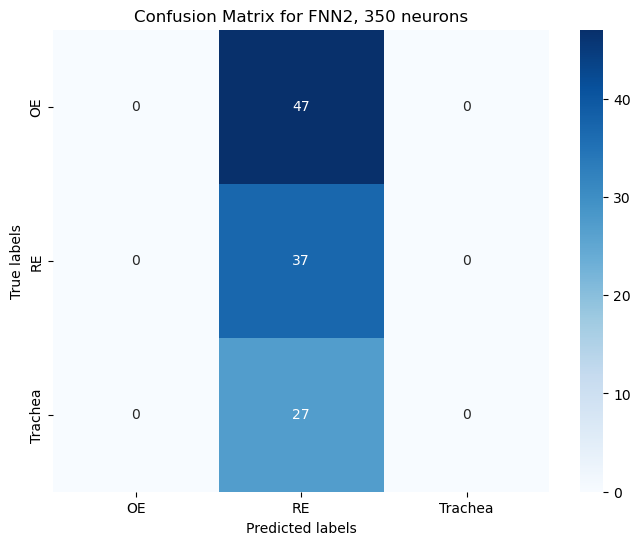

/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Evaluation for FNN4, 400 neurons:
              precision    recall  f1-score   support

          OE       0.42      1.00      0.59        47
          RE       0.00      0.00      0.00        37
     Trachea       0.00      0.00      0.00        27

    accuracy                           0.42       111
   macro avg       0.14      0.33      0.20       111
weighted avg       0.18      0.42      0.25       111



/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


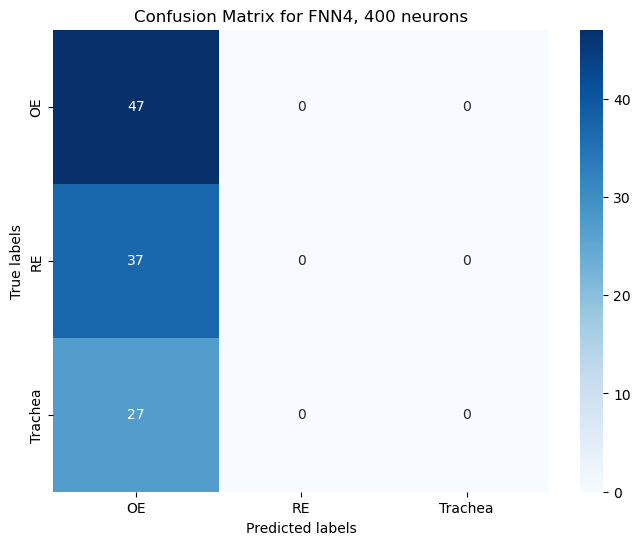

/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Evaluation for FNN8, 300 neurons:
              precision    recall  f1-score   support

          OE       0.00      0.00      0.00        47
          RE       0.33      1.00      0.50        37
     Trachea       0.00      0.00      0.00        27

    accuracy                           0.33       111
   macro avg       0.11      0.33      0.17       111
weighted avg       0.11      0.33      0.17       111



/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leokavallaris/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


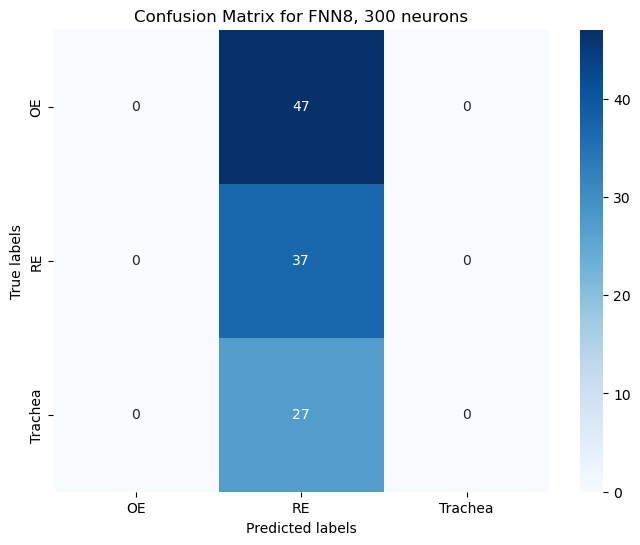

In [27]:
# Combine the average spectral data into one dataset and create labels
X = np.vstack([data_oe, data_re, data_trachea])
y = np.array([0] * len(data_oe) + [1] * len(data_re) + [2] * len(data_trachea))

# Split the data into a temporary training dataset and final test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary training dataset into actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Neural Network model training
def create_model(input_neurons, num_hidden_layers, hidden_neurons, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(input_neurons, input_shape=(X_train.shape[1],), kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(X_train.shape[1])), activation='selu'))
    for _ in range(num_hidden_layers):
        model.add(Dense(hidden_neurons, kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(hidden_neurons)), activation='selu'))
        model.add(Dropout(0.9))
    model.add(Dense(3, kernel_initializer=RandomNormal(mean=0.0, stddev=1/np.sqrt(hidden_neurons)), activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Parameters for the neural network architecture
input_neurons = 17
hidden_layers = [2, 4, 8]
hidden_neurons = [350, 400, 300]

# Training configurations
learning_rate = 0.1
epochs = 200

# Loop through each network configuration
for num_layers, num_neurons in zip(hidden_layers, hidden_neurons):
    model = create_model(input_neurons=input_neurons, num_hidden_layers=num_layers, hidden_neurons=num_neurons, learning_rate=learning_rate)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print(f"\nEvaluation for FNN{num_layers}, {num_neurons} neurons:")
    print(classification_report(y_test, y_pred, target_names=['OE', 'RE', 'Trachea']))
    
    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['OE', 'RE', 'Trachea'], yticklabels=['OE', 'RE', 'Trachea'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for FNN{num_layers}, {num_neurons} neurons')
    plt.show()

In [28]:
# Überprüfen der verwendeten Wellenlängen nach dem Zuschnitt
used_wavenumbers = common_wavenumbers[(common_wavenumbers >= 900) & (common_wavenumbers <= 1800)]
print("Verwendete Wellenlängen:", used_wavenumbers)

# Überprüfen der Form der Trainingsdaten nach dem Zuschnitt
print("Shape der Trainingsdaten:", X_train.shape)
print("Erwartete Anzahl der Features (Wellenlängen):", len(used_wavenumbers))


Verwendete Wellenlängen: [1800 1799 1798 1797 1796 1795 1794 1793 1792 1791 1790 1789 1788 1787
 1786 1785 1784 1783 1782 1781 1780 1779 1778 1777 1776 1775 1774 1773
 1772 1771 1770 1769 1768 1767 1766 1765 1764 1763 1762 1761 1760 1759
 1758 1757 1756 1755 1754 1753 1752 1751 1750 1749 1748 1747 1746 1745
 1744 1743 1742 1741 1740 1739 1738 1737 1736 1735 1734 1733 1732 1731
 1730 1729 1728 1727 1726 1725 1724 1723 1722 1721 1720 1719 1718 1717
 1716 1715 1714 1713 1712 1711 1710 1709 1708 1707 1706 1705 1704 1703
 1702 1701 1700 1699 1698 1697 1696 1695 1694 1693 1692 1691 1690 1689
 1688 1687 1686 1685 1684 1683 1682 1681 1680 1679 1678 1677 1676 1675
 1674 1673 1672 1671 1670 1669 1668 1667 1666 1665 1664 1663 1662 1661
 1660 1659 1658 1657 1656 1655 1654 1653 1652 1651 1650 1649 1648 1647
 1646 1645 1644 1643 1642 1641 1640 1639 1638 1637 1636 1635 1634 1633
 1632 1631 1630 1629 1628 1627 1626 1625 1624 1623 1622 1621 1620 1619
 1618 1617 1616 1615 1614 1613 1612 1611 1610 1609 1